In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
rf.stylely()
skrf_color_names = ['blue','red','green','orange','purple','pink','grey']
skrf_colors = dict(zip(skrf_color_names, rf.plotting.colors()))
import math

[1. 2. 3. 4. 5.]
1.1512925464970227
100
0.3162277660168382
[  0.00  25.00  50.00  75.00 100.00]


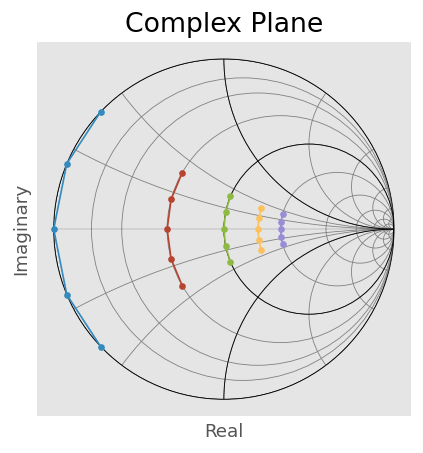

In [2]:
def r_range(start, stop, num_steps):
    r = np.linspace(1, num_steps, num_steps)
    print(r)
    k = np.log(start/stop)/(1-num_steps)
    print(k)
    print(stop)
    a0 = stop*np.exp(-k*num_steps)
    print(a0)
    for i in range(num_steps):
        r[i] = a0*np.exp(k*(i+1))
        
    return r

z0 = 50
r = r_range(1, 100, 5)
r = np.linspace(0, 100, 5)
x = np.linspace(-20, 20, 5)
zr, zx = np.meshgrid(r,x)
z = zr + 1j*zx

print(np.array2string(r, precision=2, floatmode='fixed'))
gamma = np.divide(z-z0, z+z0)
#print(gamma)

rf.plotting.plot_smith(gamma, marker='o')

In [3]:
#x = np.linspace(0,50,100)
# For gamma in a + jb format
z0 = 50
gamma = 0.5 +1j*0.0
z = z0* np.divide((1-gamma), 1.000001+gamma)
print(f'Gamma {gamma:.02f} is {z:.02f} ohms given Z0={z0:.02f}')

Gamma 0.50+0.00j is 16.67+0.00j ohms given Z0=50.00


In [4]:
import pwdatatools as pw
ds = pw.file_read(r'Manual_LP_15W.ds')

INFO : Read file Manual_LP_15W.h5


In [5]:
# List available variables with indexes
# TODO: load indexes into a map for easy access
for index, db in enumerate(ds.blocks):
    print(f'{index}: {db.dvarnames}')

0: ['Mix[1]', 'Vgs', 'Vin', 'VDD', 'Vout', 'X1.S1', 'X1.S2', 'X1.SP1', 'X1.SN1', 'X1.S1_common', 'X1.SP2', 'X1.SN2', 'X1.S2_common', 'SRC1.i', 'SRC2.i', 'Iout.i', 'IDD.i', 'Iin.i', 'Igs.i']
1: ['L_Gamma']
2: ['Gp']
3: ['DCRF']
4: ['PAE']
5: ['PAE1']
6: ['Pfc_out']
7: ['Pfc_in']
8: ['Pfc_dc']
9: ['Zgs']
10: ['FET.Q1.Tj']
11: ['FET.Q1.idi']
12: ['S[1,1]', 'PortZ[1]']
13: ['FET.Q1.vdsi']
14: ['Zinput']
15: ['Pout']
16: ['Pout_dBm']
17: ['Pin']
18: ['Pin_dBm']
19: ['PDC']
20: ['Gt']


In [7]:
# Demonstrate viewing data relationships within a datablock
block_num = 16
print(ds.blocks[block_num].ivarnames)
print(ds.blocks[block_num].dvarnames)
print(ds.blocks[block_num].dependencies)
print(ds.blocks[block_num].what('Pout_dBm'))

['rho_im', 'rho_re']
['Pout_dBm']
rho_im                ['rho_im']
rho_re      ['rho_im', 'rho_re']
Pout_dBm    ['rho_im', 'rho_re']
Name: dependencies, dtype: object
tags                            dvar
dependencies    ['rho_im', 'rho_re']
numpts                           325
datatypes                    float64
Name: Pout_dBm, dtype: object


In [8]:
# Pretty print info about each independent variable
block = ds.blocks[16]
for ivarname in block.ivarnames:
    print(f'{ivarname}')
    print(block.what(f'{ivarname}'))
    print('\n')
    
print(block.datatypes)
print(block.datanames)

rho_im
tags                  ivar
dependencies    ['rho_im']
numpts                  13
datatypes          float64
Name: rho_im, dtype: object


rho_re
tags                            ivar
dependencies    ['rho_im', 'rho_re']
numpts                            25
datatypes                    float64
Name: rho_re, dtype: object


rho_im      float64
rho_re      float64
Pout_dBm    float64
Name: datatypes, dtype: object
['rho_im', 'rho_re', 'Pout_dBm']


In [9]:
block = ds.blocks[0]
# Slice variables on a specific frequency
data = block.variables[block.variables['freq'] == 3.600000e+09]

# I can't remember what I was trying to do here?
data = data[data.columns.drop(list(data.filter(regex='bonding')))]

rho_im = data.get('rho_im').to_numpy()
rho_re = data.get('rho_re').to_numpy()

(-1.1, 1.1, -1.1, 1.1)

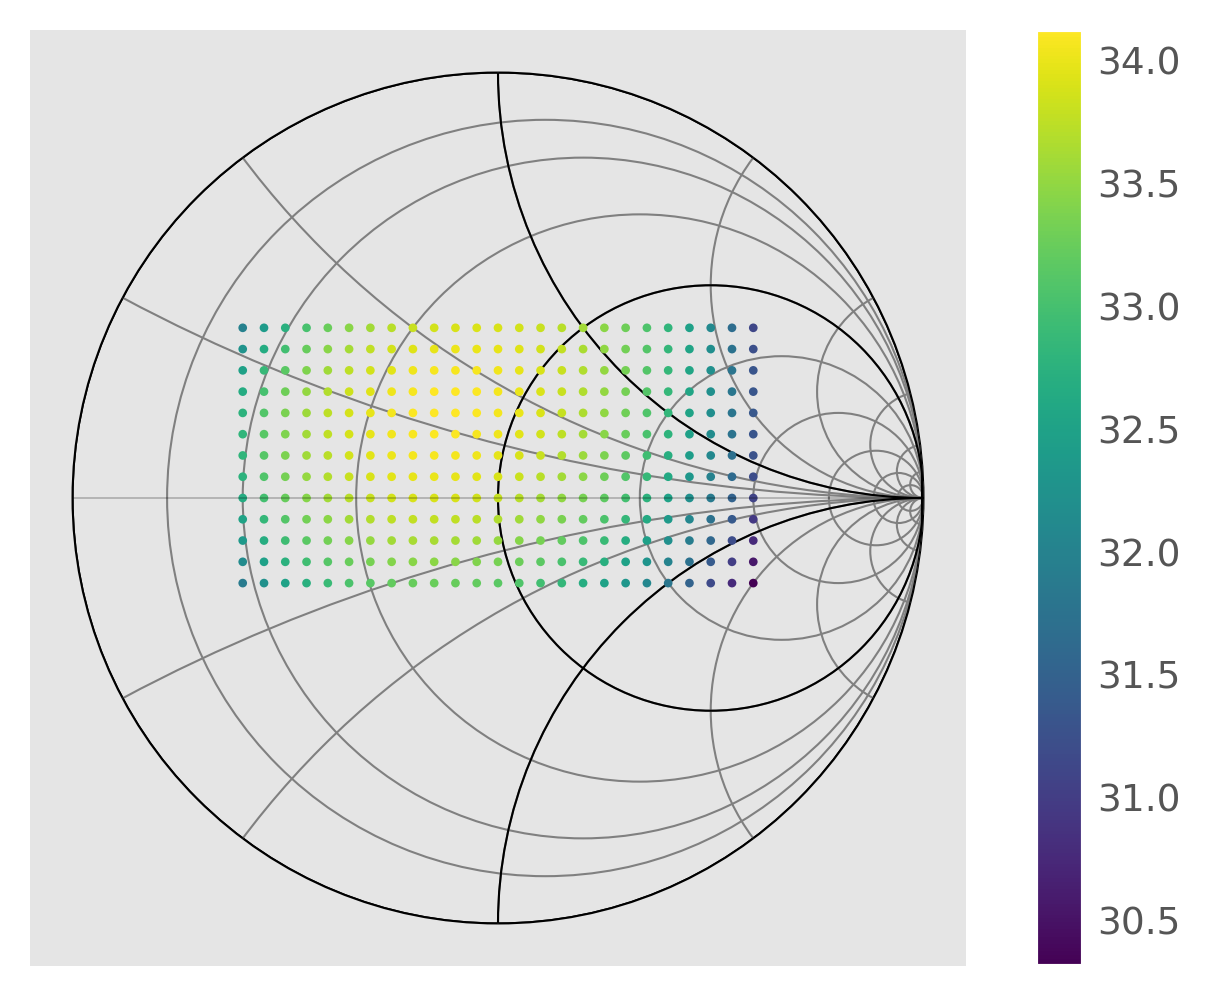

In [10]:
plt.rcParams['figure.dpi'] = 300
fig, axes = plt.subplots()
rf.plotting.smith(ax=axes)

z = np.real(ds.blocks[16]['Pout_dBm'].to_numpy())

#axes.plot(rho_re,rho_im, marker='.', color=skrf_colors['blue'], linestyle='None', markersize=1)
graph = axes.scatter(rho_re, rho_im, c=z, s=10, marker='.', cmap='viridis', linestyle='None')
fig.colorbar(graph)
axes.axis(1*np.array([-1.1, 1.1, -1.1, 1.1]))

[30.  30.5 31.  31.5 32.  32.5 33.  33.5 34. ]


(-1.1, 1.1, -1.1, 1.1)

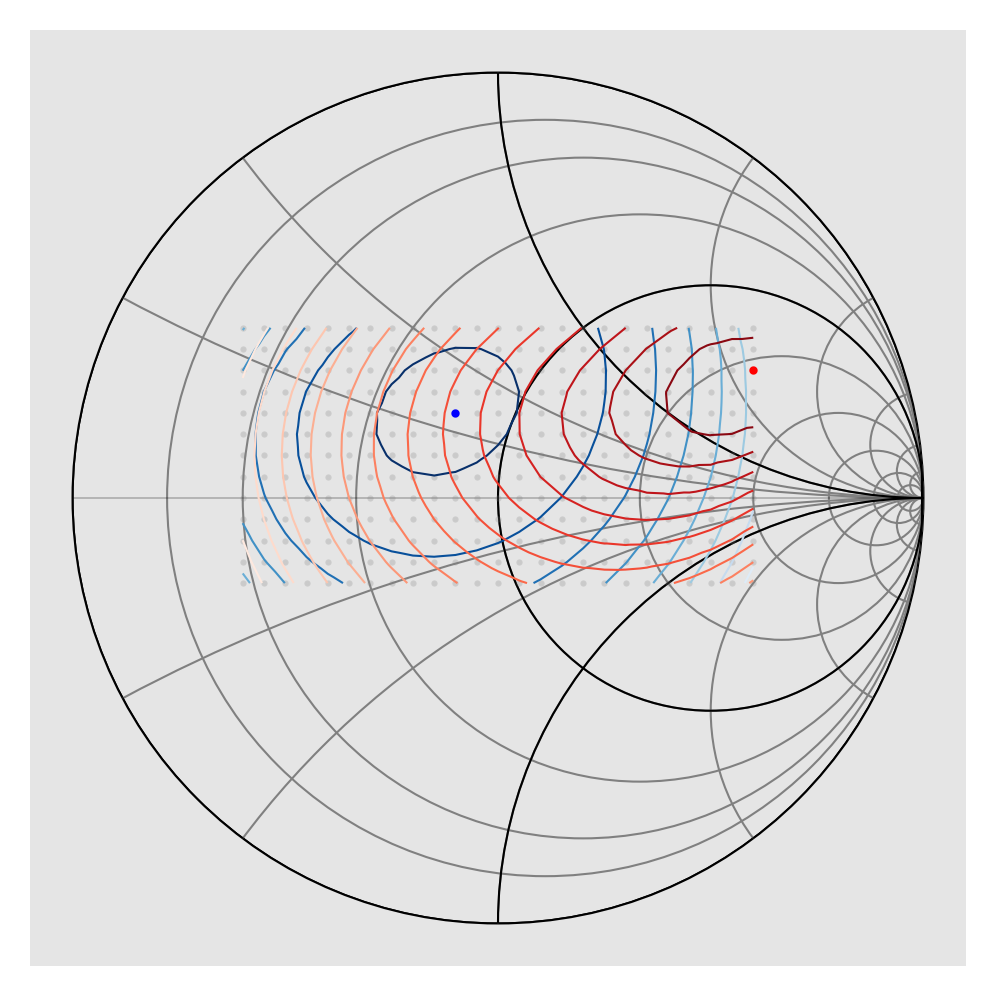

In [12]:
fig, ax = plt.subplots()
rf.plotting.smith(ax=ax)

import matplotlib.tri as tri

x = rho_re
y = rho_im

# Pout
z = np.real(ds.blocks[16]['Pout_dBm'].to_numpy())

# Plot loadpull grid
ax.plot(x, y, marker='.', color="grey", markersize=1, linestyle='None', alpha=0.25)

# Plot Pout contours
z_min = np.floor(np.min(z))
z_max = np.round(np.max(z))
levels = np.linspace(z_min, z_max, int((z_max-z_min)/0.5)+1)
print(levels)
max_index = np.argmax(z)

# contour1 plots contour levels as lines without an area fill
contour1=ax.tricontour(x, y, z, levels=levels, linewidths=0.5, cmap="Blues")

# contour plots contour levels as areas of different colors
#contour = ax.tricontourf(x, y, z, levels=10, cmap="RdBu_r")

ax.plot(x[max_index], y[max_index], 'bo', markersize=1)

#ax.clabel(contour, inline=True, fontsize=5)
#fig.colorbar(contour, ax=ax)

# Plot PAE contours
z2 = np.real(ds.blocks[4]['PAE'].to_numpy())
z_min = np.floor(np.min(z2))
z_max = np.round(np.max(z2))
levels = np.linspace(z_min, z_max, int((z_max-z_min)/2.5+1))
#print(levels)

contour2 = ax.tricontour(x, y, z2, levels=levels, linewidths=0.5, cmap="Reds")

# Plot maximum point
max_index = np.argmax(z2)
ax.plot(x[max_index], y[max_index], 'ro', markersize=1)

# Need to check if the colorbar is handling PAE and Pout simultaneously. If so, is it possible to put in two color bars?
#ax.clabel(contour, inline=True, fontsize=5)
#fig.colorbar(contour, ax=ax)

ax.axis(1*np.array([-1.1, 1.1, -1.1, 1.1]))

C:\Users\derek\Miniconda3\envs\ads\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[Text(137.0, 0.5, 'Output Power (dBm)'),
 Text(0.5, 76.74999999999999, 'Power Added Efficiency (%)'),
 Text(0.5, 1.0, 'Efficiency vs Power'),
 (30.0, 35.0),
 (10.0, 50.0)]

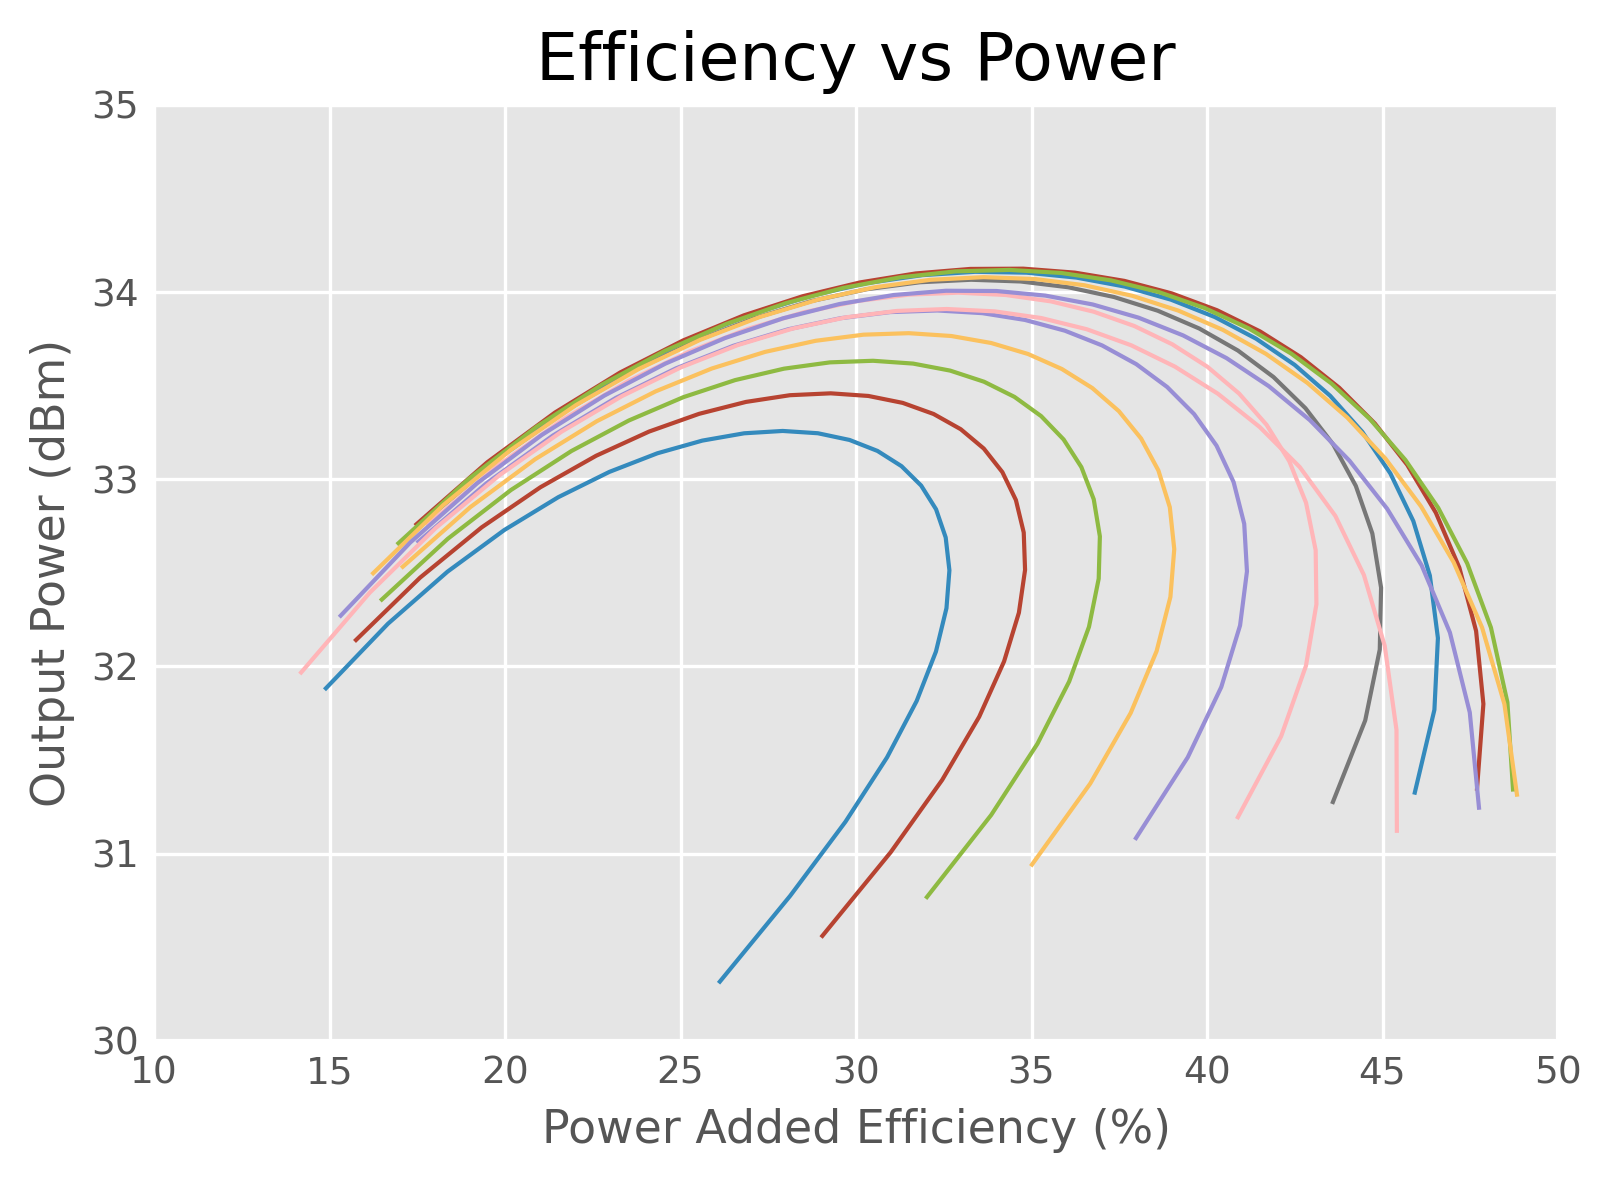

In [13]:
y = ds.blocks[16]['Pout_dBm'].to_numpy()
# Examine the dependencies of Pout_dBm
#print(ds.blocks[16].what('Pout_dBm'))

x = ds.blocks[4]['PAE'].to_numpy()
# Examine the dependencies of Pin_dBm
#print(ds.blocks[4].what('PAE'))

# Both depend on rho_re and rho_im, so grab those dimensions to setup sweep
rho_re = ds.blocks[16].what('rho_re').numpts
rho_im = ds.blocks[16].what('rho_im').numpts

#print(rho_re)
#print(rho_im)

y = y.reshape(rho_im, rho_re).transpose()
x = x.reshape(rho_im, rho_re).transpose()

#print(np.shape(y))

fig, ax = plt.subplots()
rf.plotting.plot_rectangular(x, y, ax=ax)
ax.set(ylabel='Output Power (dBm)',
       xlabel='Power Added Efficiency (%)',
       title='Efficiency vs Power',
       ylim=[30,35],
       xlim=[10,50])

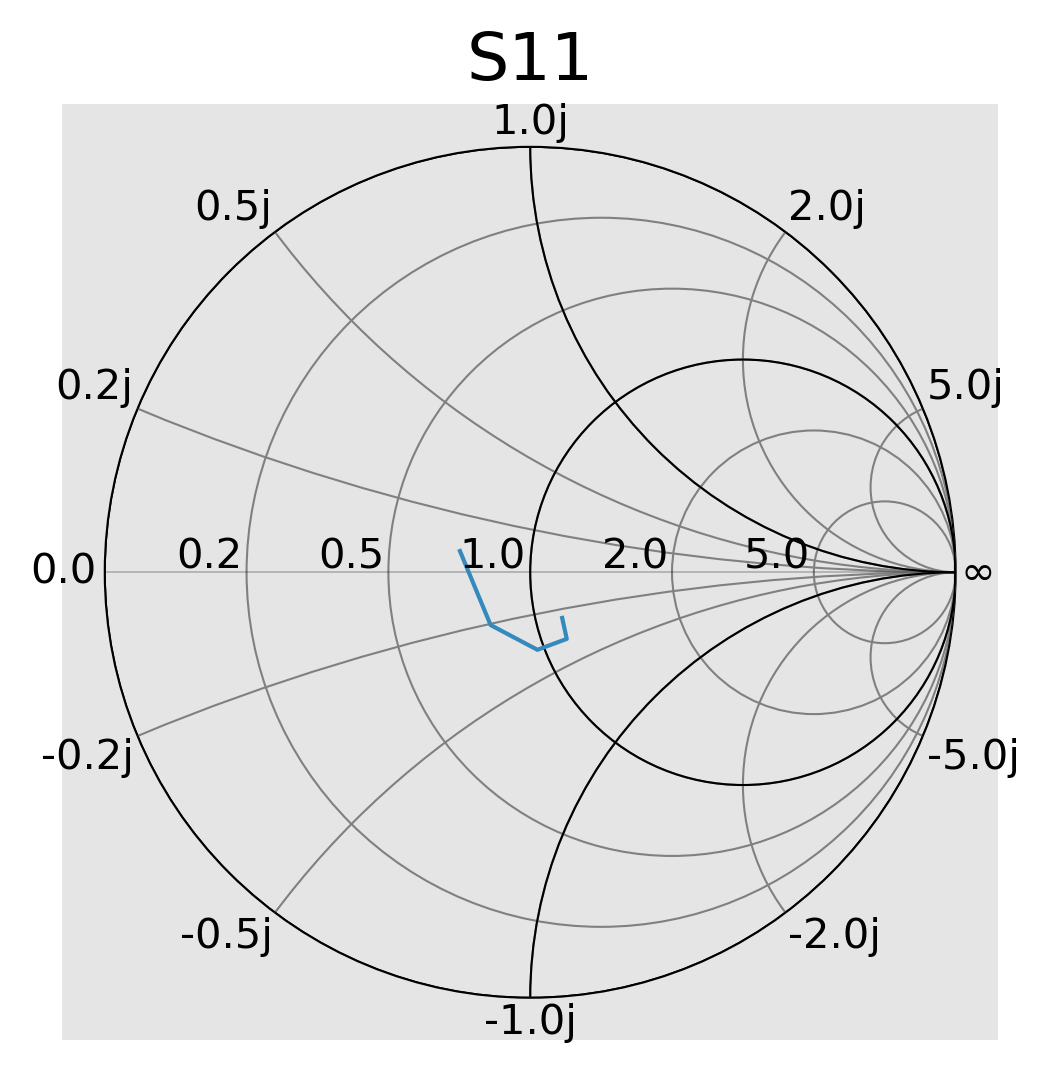

In [14]:
s11 = ds.blocks[12]['S[1,1]'].to_numpy()

# Todo, add a label style to make them less intrusive to the plot
rf.plotting.smith(draw_labels=True)
rf.plotting.plot_smith(s11,title="S11",y_label="", x_label="")